In [4]:
!pip install tensorflow
!pip install alpha_vantage

Enter stock ticker symbols separated by commas (e.g., AAPL, TSLA): aapl

🔁 Processing stock: AAPL
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - loss: 0.0147 - val_loss: 5.0318e-04 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - loss: 0.0033 - val_loss: 6.1934e-04 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - loss: 0.0016 - val_loss: 4.2665e-04 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 160ms/step - loss: 0.0012 - val_loss: 3.9924e-04 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - loss: 0.0013 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - loss: 0.0012 - val_loss: 7.6344e-04 - learning_rate: 0.0010
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - loss: 0.0011 - val_loss: 2

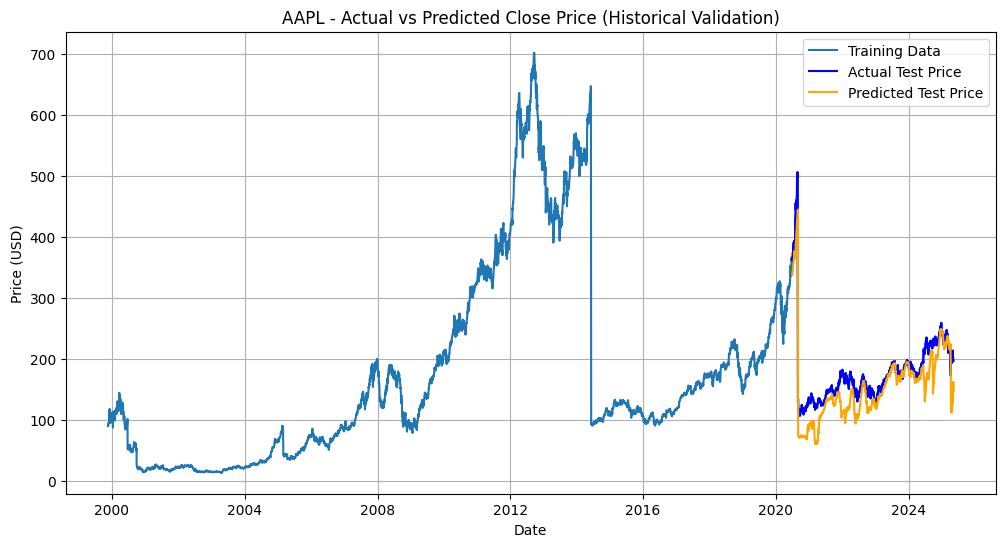

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

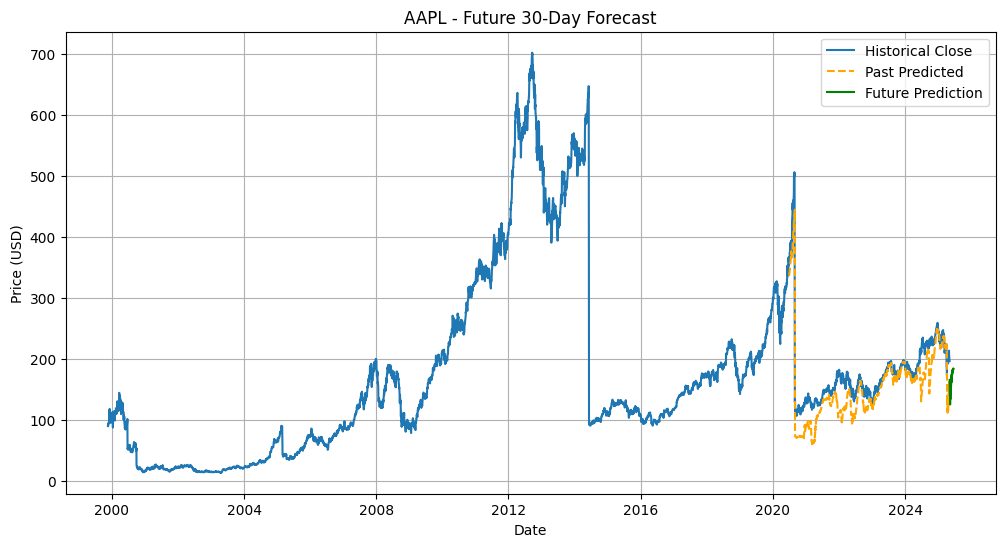

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Attention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math

# Enter your Alpha Vantage API Key
API_KEY = 'K4B0QZ0DAY135ZQR'  # Replace with your real API key

# Initialize Alpha Vantage API
ts = TimeSeries(key=API_KEY, output_format='pandas')

# Get user input
tickers = input("Enter stock ticker symbols separated by commas (e.g., AAPL, TSLA): ").upper().split(',')

def compute_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

for ticker in tickers:
    ticker = ticker.strip()
    print(f"\n🔁 Processing stock: {ticker}")

    try:
        data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
        data = data[['4. close', '5. volume']]
        data.rename(columns={'4. close': 'Close', '5. volume': 'Volume'}, inplace=True)
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        continue

    if data.empty:
        print(f"No data for {ticker}. Skipping.")
        continue

    # Technical indicators
    data['SMA'] = data['Close'].rolling(window=14).mean()
    data['EMA'] = data['Close'].ewm(span=14, adjust=False).mean()
    data['RSI'] = compute_rsi(data)
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    data['Volume_scaled'] = MinMaxScaler().fit_transform(data[['Volume']])
    data.dropna(inplace=True)

    # Scale features
    feature_cols = ['Close', 'SMA', 'EMA', 'RSI', 'LogReturn', 'Volume_scaled']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[feature_cols])

    train_len = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_len]
    test_data = scaled_data[train_len:]

    # Create training sequences
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i])
        y_train.append(train_data[i, 0])  # Close price

    x_train, y_train = np.array(x_train), np.array(y_train)

    # Model architecture
    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(100, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = create_attention_layer(x)
    x = Bidirectional(LSTM(100))(x)
    x = Dropout(0.3)(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
              callbacks=[early_stop, reduce_lr], verbose=1)

    # Test data prep
    x_test, y_test = [], []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i])
        y_test.append(test_data[i, 0])

    x_test, y_test = np.array(x_test), np.array(y_test)

    # Predict on historical test set
    predictions = model.predict(x_test)
    predictions_rescaled = scaler.inverse_transform(
        np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1)))
    ))[:, 0]

    rmse = math.sqrt(mean_squared_error(
        scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_data.shape[1] - 1)))) )[:, 0],
        predictions_rescaled
    ))
    print(f"{ticker} RMSE on test set: {rmse:.2f}")

    valid = data.iloc[train_len:].copy().iloc[60:]  # Align with predictions
    valid['Predictions'] = predictions_rescaled[:len(valid)]

    # Plot historical prediction
    plt.figure(figsize=(12, 6))
    plt.title(f"{ticker} - Actual vs Predicted Close Price (Historical Validation)")
    plt.plot(data['Close'], label="Training Data")
    plt.plot(valid['Close'], label="Actual Test Price", color='blue')
    plt.plot(valid['Predictions'], label="Predicted Test Price", color='orange')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{ticker}_historical_prediction.png")
    plt.show()

    # Future forecasting
    future_days = 30
    future_predictions = []
    last_60_days = scaled_data[-60:].reshape(1, 60, scaled_data.shape[1])

    for _ in range(future_days):
        pred = model.predict(last_60_days)[0][0]
        future_predictions.append(pred)
        next_input = np.append(last_60_days[:, 1:, :], [[[pred] + [0] * (scaled_data.shape[1] - 1)]], axis=1)
        last_60_days = next_input

    future_predictions_rescaled = scaler.inverse_transform(
        np.hstack((np.array(future_predictions).reshape(-1, 1), np.zeros((future_days, scaled_data.shape[1] - 1)))
    ))[:, 0]

    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='B')

    # Plot future forecast
    plt.figure(figsize=(12, 6))
    plt.title(f"{ticker} - Future {future_days}-Day Forecast")
    plt.plot(data['Close'], label="Historical Close")
    plt.plot(valid['Predictions'], label="Past Predicted", color='orange', linestyle='--')
    plt.plot(future_dates, future_predictions_rescaled, label="Future Prediction", color='green')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{ticker}_future_forecast.png")